# **CS224W - Colab 4**

In this Colab, we will shift our focus from homogenous graphs to heterogeneous graphs. Heterogeneous graphs extend the traditional homogenous graphs that we have seen before by specifically incorperating different node and edge types. This additional information allows us to extend the graph neural nework models that we have worked with before. Namely, we can apply heterogenous message passing, where different message types now exist between different node, edge type relationships. 

At first, we will learn how to transform NetworkX graphs into DeepSNAP representations. Additionally, we will dive deeper into how DeepSNAP stores and represents heterogeneous graphs as PyTorch Tensors.

Then, we will build our own heterogenous graph neural netowrk models using PyTorch Geonetric and DeepSNAP on node property prediction task. To evaluate these models, we will use our model on the heterogeneous ACM dataset.

**Note**: Make sure to **sequentially run all the cells in each section**, so that the intermediate variables / packages will carry over to the next cell

Have fun on Colab 4 :)

# **CS224W - Colab 4**

在这个 Colab 中，我们将把注意力从同构图转移到异构图。异构图通过专门合并不同的节点和边类型，扩展了我们之前看到的传统同构图。这些附加信息使我们能够扩展我们之前使用过的图神经网络模型。也就是说，我们可以应用异构消息传递（heterogenous message passing），其中不同的节点、边类型关系之间现在存在不同的消息类型。

首先，我们将学习如何将 NetworkX 图转换为 DeepSNAP 表示。此外，我们将深入探讨 DeepSNAP 如何将异构图存储和表示为 PyTorch 张量。

然后，我们将在节点属性预测任务上使用 PyTorch Geonetric 和 DeepSNAP 构建我们自己的异构图神经网络模型。为了评估这些模型，我们将在异构 ACM 数据集上使用我们的模型。

**注意**：确保**依次运行每个部分中的所有单元格**，以便中间变量/包会延续到下一个单元格

在 Colab 4 上玩得开心 :)

# Device
You might need to use GPU for this Colab.

Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.

# Installation

In [1]:
'''!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git
!pip install -U -q PyDrive'''

'!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html\n!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html\n!pip install -q torch-geometric\n!pip install -q git+https://github.com/snap-stanford/deepsnap.git\n!pip install -U -q PyDrive'

In [2]:
import torch_geometric
torch_geometric.__version__

'1.7.1'

# 1 DeepSNAP Heterogeneous Graph

First, we will explore how to transform NetworkX graphs into the format supported by DeepSNAP. 

In order to extend the traditional DeepSNAP representation of graphs to include heterogenous graphs, we include the following graph property features:
* `node_feature`: The feature of each node (`torch.tensor`)
* `edge_feature`: The feautre of each edge (`torch.tensor`)
* `node_label`: The label of each node (`int`)
* `node_type`: The node type of each node (`string`)
* `edge_type`: The edge type of each edge (`string`)

The key new features we add are `node_type` and `edge_type`, which enables us to perform heterogenous message passing.

In this first question we will work with the familiar [karate club graph](https://networkx.github.io/documentation/stable/auto_examples/graph/plot_karate_club.html) seen in assignment one. To start, since each node in the graph belongs to one of two clubs (club "Mr. Hi" or club "Officer"), we will treat the club as the `node_type`. The code below demonstrates how to differentiate the nodes in the NetworkX graph.


# 1 DeepSNAP 异构图（Heterogeneous Graph）

首先，我们将探讨如何将 NetworkX 图转换为 DeepSNAP 支持的格式。

为了支持异构图，我们扩展图的传统 DeepSNAP 表示，我们包含以下图属性特征：
* `node_feature`: 每个节点的特征 (`torch.tensor`)
* `edge_feature`: 每个边的特征 (`torch.tensor`)
* `node_label`: 每个节点的标签 (`int`)
* `node_type`: 每个节点的类型 (`string`)
* `edge_type`: 每个边的类型 (`string`)

我们添加的关键新特性是 `node_type` 和 `edge_type`，它们使我们能够执行异构消息传递。

在这第一个问题里，我们还是用老朋友 [空手道俱乐部](https://networkx.github.io/documentation/stable/auto_examples/graph/plot_karate_club.html) 。
首先，既然每个节点都属于两个俱乐部中的一个 (即 "Mr. Hi" 或者  "Officer"), 我们将把俱乐部视为 `node_type`.

下面的代码将展示如何在 NetworkX 图中区分节点.


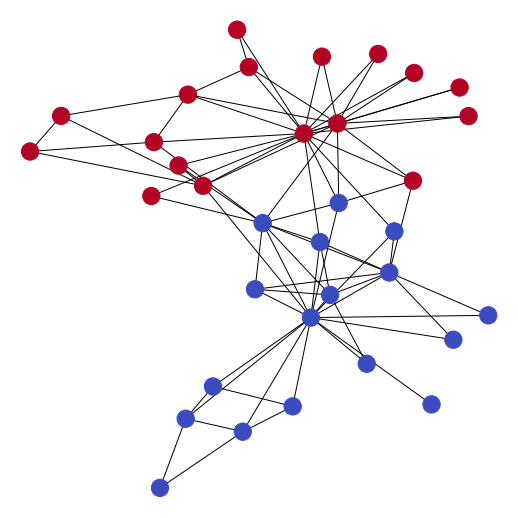

In [3]:
from pylab import *
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
import copy

G = nx.karate_club_graph()
community_map = {}
for node in G.nodes(data=True):
    if node[1]["club"] == "Mr. Hi":
        community_map[node[0]] = 0
    else:
        community_map[node[0]] = 1
node_color = []
color_map = {0: 0, 1: 1}
node_color = [color_map[community_map[node]] for node in G.nodes()]
pos = nx.spring_layout(G)
#https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html
plt.figure(figsize=(7, 7))
nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=node_color)
show()

In [4]:
# EX：看看节点里都是个啥：
for node in G.nodes(data=True):
    print('设置 data = True 时的 node：', node)
    print(node[0])
    print(node[1])
    break

for node in G.nodes():
    print('没设置 data = True 时的 node：',node)
    break

设置 data = True 时的 node： (0, {'club': 'Mr. Hi'})
0
{'club': 'Mr. Hi'}
没设置 data = True 时的 node： 0


### Question 1.1: Assigning Node Type and Node Features (Not Specifically Graded)

Using the `community_map` dictionary and graph `G` from above, add node attributes `node_type` and `node_label` to the graph G. Namely, for `node_type` assign nodes in the "Mr. Hi" club to a node type `n0` and nodes in club "Officer" a node type `n1`. 

Then for `node_label`, assign nodes in "Mr. Hi" club to a `node_label` `0` and nodes in club "Officer" a `node_label` of `1`.

Lastly, assign every node a feature vector [1, 1, 1, 1, 1]. 

**Hint**: Look at the NetworkX function `nx.classes.function.set_node_attributes`.

**Note**: This question is not specifically graded but is important for later questions.

### Question 1.1: 分配节点类型和节点特征

使用 `community_map` 字典和图 `G`, 将节点属性 `node_type` 和 `node_label` 加到图 G 上. 也就是说, 对于 "Mr. Hi" 的节点分配 `node_type` 为 `n0` 而 "Officer" 分配的是 `n1`. 

之后对于 `node_label`, 分配 "Mr. Hi" 节点的 `node_label` 为 `0` ，而 "Officer" 的 `node_label` 为 `1`.

最后, 给每个节点分配一个特征向量 [1, 1, 1, 1, 1]. 

**提示**: 可以参考 NetworkX 的这个函数： `nx.classes.function.set_node_attributes`.


In [5]:
import torch

def assign_node_types(G, community_map):
    # TODO: Implement this function that takes in a NetworkX graph
    # G and community map assignment (mapping node ids --> 0/1 labels)
    # and adds 'node_type' as a node_attribute in G.
    '''
    TODO: 实现这个函数，接受一个 NetworkX 图 G 以及一个 community_map 分配映射
    （分配映射值将 node ids ——> 0/1 标签）为输入。
    将 'node_type' 作为 node_attribute 添加到 G 中
    '''
    ############# Your code here ############
    ## (~2 line of code)
    ## Note
    ## 1. Look up NetworkX `nx.classes.function.set_node_attributes`
    '''
    至多两行代码，注意：可以看看参考
    NetworkX 的 `nx.classes.function.set_node_attributes` 函数
    '''
    new_cm={}
    for (k,v) in community_map.items():
        if v==0:
            new_cm[k]='n0'
        else:
            new_cm[k]='n1'
    #我参考的答案里一种比较优雅的写法：
    #node_type_map = {0:'n0', 1:'n1'}
    #node_types = {node:node_type_map[community_map[node]] for node in G.nodes()}
    nx.set_node_attributes(G,new_cm,'node_type')
 
    #########################################

def assign_node_labels(G, community_map):
    # TODO: Implement this function that takes in a NetworkX graph
    # G and community map assignment (mapping node ids --> 0/1 labels)
    # and adds 'node_label' as a node_attribute in G.
    '''
    TODO: 实现函数，接收一个 NetworkX 图 G 以及社区映射分配（映射节点 id → 0/1标签）
    将 'node_label' 作为一个 node_attribute 添加到 G 中
    '''
    ############# Your code here ############
    ## (~2 line of code)
    ## Note
    ## 1. Look up NetworkX `nx.classes.function.set_node_attributes`
    '''
    之多两行代码，注意参考
     NetworkX 的 `nx.classes.function.set_node_attributes`
    '''
    nx.set_node_attributes(G,community_map,'node_label')
    #########################################

def assign_node_features(G):
    # TODO: Implement this function that takes in a NetworkX graph
    # G and adds 'node_feature' as a node_attribute in G. Each node
    # in the graph has the same feature vector [1., 1., 1., 1., 1.]
    '''
    TODO: 实现函数，接收一个 NetworkX 图 G 作为输入，
    将 'node_feature' 作为 node_attribute 添加到 G 中
    每个节点都有相同的特征向量 [1., 1., 1., 1., 1.]
    '''
    ############# Your code here ############
    ## (~2 line of code)
    ## Note
    ## 1. Look up NetworkX `nx.classes.function.set_node_attributes`
    '''
    至多2行，注意参考
    NetworkX 的 `nx.classes.function.set_node_attributes` 函数 
    '''
    feature_vector=[1, 1, 1, 1, 1]
    nx.set_node_attributes(G,feature_vector,'node_feature')
    #########################################

assign_node_types(G, community_map)
assign_node_labels(G, community_map)
assign_node_features(G)


### Question 1.2: Assigning Edge Types (Not Specifically Graded)

Next, we will assign three different types of `edge_type` to the edges: 
* Edges within club "Mr. Hi": `e0`
* Edges within club "Officer": `e1`
* Edges between clubs: `e2`

**Hint**: Use the `community_map` from before and `nx.classes.function.set_edge_attributes`

### 问题 1.2: 分配变类型

之后我们要给边分配三种不同的 `edge_type`:
* 在 "Mr. Hi" 节点间的边: `e0`
* 在 "Officer" 节点间的边: `e1`
* 在 "Mr. Hi"、"Officer" 节点间的边: `e2`

**提示**: 使用之前的 `community_map` 以及 `nx.classes.function.set_edge_attributes`

In [6]:
def assign_edge_types(G, community_map):
    # TODO: Implement this function that takes in a NetworkX graph
    # G and community map assignment (mapping node ids --> 0/1 labels)
    # and adds 'edge_type' as a edge_attribute in G.
    '''
    TODO: 实现函数，接收 NetworkX 图 G 作为和社区映射分配作为输入（映射节点 id → 0/1 标签）
    并且将 'edge_type' 作为 edge_attribute 添加到 G 中
    '''
    ############# Your code here ############
    ## (~5 line of code)
    ## Note
    ## 1. Create an edge assignment dict following rules above
    '''
    至多五行代码，注意：
    按照题目要求创建一个边分配字典即可
    '''
    edge2attr_map = {}
    for edge in G.edges():
        if G.nodes[edge[0]]['club']=='Mr. Hi' and G.nodes[edge[1]]['club']=='Mr. Hi':
            edge2attr_map[edge]='e0'
        elif G.nodes[edge[0]]['club']=='Officer' and G.nodes[edge[1]]['club']=='Officer':
            edge2attr_map[edge]='e1'
        else:
            edge2attr_map[edge]='e2'
    nx.set_edge_attributes(G,edge2attr_map,'edge_type')

  #########################################

assign_edge_types(G, community_map)

## Heterogeneous Graph Visualization

Now we can visualize the Heterogeneous Graph we have generated.

## 异构图可视化

现在我们就可以可视化生成的异构图了！


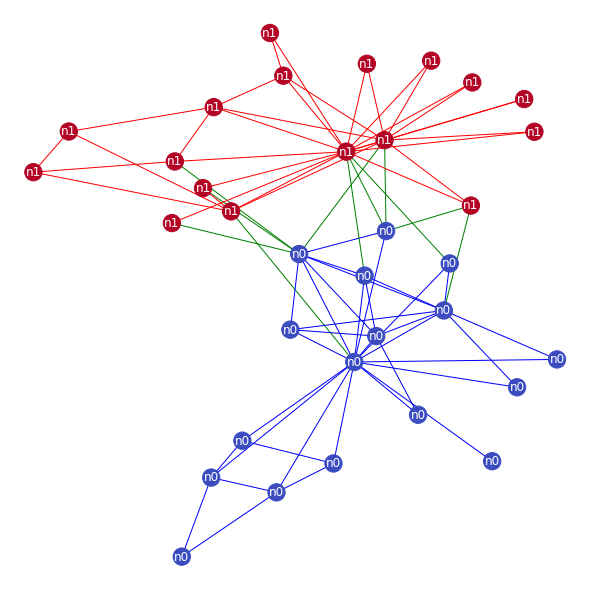

In [7]:
edge_color = {}
for edge in G.edges():
    n1, n2 = edge
    edge_color[edge] = community_map[n1] if community_map[n1] == community_map[n2] else 2
    if community_map[n1] == community_map[n2] and community_map[n1] == 0:
        edge_color[edge] = 'blue'
    elif community_map[n1] == community_map[n2] and community_map[n1] == 1:
        edge_color[edge] = 'red'
    else:
        edge_color[edge] = 'green'

G_orig = copy.deepcopy(G)
nx.classes.function.set_edge_attributes(G, edge_color, name='color')
colors = nx.get_edge_attributes(G,'color').values()
labels = nx.get_node_attributes(G, 'node_type')
plt.figure(figsize=(8, 8))
nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=node_color, edge_color=colors, labels=labels, font_color='white')
show()

which include edges within each clubs (2 types) and edges across two clubs (1 type). Different types of nodes and edges are visualized in different colors. The NetworkX object `G` in following code can be transformed into `deepsnap.hetero_graph.HeteroGraph` directly.

## Transforming to DeepSNAP representation

The NetworkX object `G` in following code can be transformed into `deepsnap.hetero_graph.HeteroGraph` directly!

其中包括每个俱乐部（就是 “Mr. Hi” 啥的）之内的边（2 种类型）和两个俱乐部之间的边（1 种类型）。 不同类型的节点和边以不同的颜色可视化。 下面代码中的 NetworkX 对象 `G` 可以直接转化为`deepsnap.hetero_graph.HeteroGraph`。

## 转换为 DeepSNAP 表示

NetworkX 对象 `G` 在之后的代码中可直接转换为 `deepsnap.hetero_graph.HeteroGraph` 哦!

In [8]:
from deepsnap.hetero_graph import HeteroGraph

hete = HeteroGraph(G_orig)

## Question 1.3: How many nodes are of each type (10 Points)

Submit your answers on Gradescope.


## 问题 1.3: 每个类别有多少个节点

可以如下代码块一样打印出节点的类型

In [10]:
print(hete.node_type)
print(len(hete.node_type['n0']))

{'n0': ['n0', 'n0', 'n0', 'n0', 'n0', 'n0', 'n0', 'n0', 'n0', 'n0', 'n0', 'n0', 'n0', 'n0', 'n0', 'n0', 'n0'], 'n1': ['n1', 'n1', 'n1', 'n1', 'n1', 'n1', 'n1', 'n1', 'n1', 'n1', 'n1', 'n1', 'n1', 'n1', 'n1', 'n1', 'n1']}
17


In [8]:
def get_nodes_per_type(hete):
    # TODO: Implement this function that takes a DeepSNAP dataset object
    # and return the number of nodes per `node_type`.
    '''
    TODO：实现函数，接收 DeepSNAP 数据集对象作为输入，返回每个 `node_type` 的节点数
    '''
    num_nodes_n0 = 0
    num_nodes_n1 = 0

    ############# Your code here ############
    ## (~2 line of code)
    ## Note
    ## 1. Colab autocomplete functionality might be useful.
    '''
    至多 2 行代码，甚至可以试试搞个代码自动补全
    '''
    num_nodes_n0=len(hete.node_type['n0'])
    num_nodes_n1=len(hete.node_type['n1'])
    #########################################

    return num_nodes_n0, num_nodes_n1

num_nodes_n0, num_nodes_n1 = get_nodes_per_type(hete)
print("Node type n0 has {} nodes".format(num_nodes_n0))
print("Node type n1 has {} nodes".format(num_nodes_n1))

Node type n0 has 17 nodes
Node type n1 has 17 nodes


## Question 1.4: Message Types: How many edges are of each message type (10 Points)

Submit your answers on Gradescope.

When working with heterogenous graphs, as we have discussed before, we now work with heterogenous message types (i.e. different message types for `node_type` and `edge_type` combinations). For example, an edge of type `e0` connecting two nodes in club "Mr. HI" would have a message type of (`n0`, `e0`, `n0`). In this problem we will analyze how many edges in our graph are of each message type.

**Hint**: If you want to learn more about what the different message types are try the call `hete.message_types`

## 问题 1.4: 消息类型（Message Types）: 每种消息类型由多少条边


在使用异构图时，正如我们之前讨论过的，我们现在使用异构消息类型（即 `node_type` 和 `edge_type` 组合的不同消息类型）。 例如，连接俱乐部 `Mr. HI` 中的两个节点的类型为 `e0` 的边将具有（`n0`、`e0`、`n0`）的消息类型。 在这个问题中，我们将分析图中每种消息类型各有多少条边。

**提示**：如果您想了解有关不同消息类型的更多信息，请尝试调用 `hete.message_types`

In [15]:
# 事不宜迟，咱们按照提示打印一下试试

print(hete.message_types)
print(hete.edge_type[hete.message_types[0]][:10])

[('n0', 'e0', 'n0'), ('n0', 'e2', 'n1'), ('n1', 'e1', 'n1')]
['e0', 'e0', 'e0', 'e0', 'e0', 'e0', 'e0', 'e0', 'e0', 'e0']


In [16]:
def get_num_message_edges(hete):
    # TODO: Implement this function that takes a DeepSNAP dataset object
    # and return the number of edges for each message type. 
    # You should return a list of tuples as 
    # (message_type, num_edge)
    '''
    TODO: 实现函数，接收一个 DeepSNAP 数据集对象作为输入，返回每种消息类型的边数
    你需要返回一个形如 (message_type, num_edge) 的元组列表
    '''
    message_type_edges = []

    ############# Your code here ############
    ## (~2 line of code)
    ## Note
    ## 1. Colab autocomplete functionality might be useful.
    '''
    至多 2 行代码：可以试试代码自动补全
    '''
    for message_type,num_edge in hete.edge_type.items():
        message_type_edges.append((message_type,len(num_edge)))
    #########################################

    return message_type_edges

message_type_edges = get_num_message_edges(hete)
for (message_type, num_edges) in message_type_edges:
    print("Message type {} has {} edges".format(message_type, num_edges))


Message type ('n0', 'e0', 'n0') has 35 edges
Message type ('n0', 'e2', 'n1') has 11 edges
Message type ('n1', 'e1', 'n1') has 32 edges


## Question 1.5: Dataset Splitting: How many nodes in each dataset split? (10 Points)

Submit your answers on Gradescope.

DeepSNAP has built in Dataset creation and splitting methods for heterogeneous graphs. Here we will create train, validation, and test datasets for a node prediction task and inspect the resulting subgraphs. Specifically, write a function that computes the number of nodes in each dataset split.


## 问题 1.5: 数据集分割: 在每一种数据集分割中有多少节点


DeepSNAP 已经实现了用于异构图的数据集创建与分割方法。这里我们将为一个节点分类任务创建训练、验证和测试集，并观察结果子图。这里写的就是计算每个数据集分割中的节点数目。



In [17]:
from deepsnap.dataset import GraphDataset

def compute_dataset_split_counts(datasets):
    # TODO: Implement this function that takes a dict of datasets
    # and returns a dict mapping dataset names to the number of labeled
    # nodes used for supervision in that respective dataset.  
    '''
    TODO: 实现函数，接收一个数据集字典为输入，
    返回一个 “数据集名：用于监督的节点数目” 的字典映射
    '''
    data_set_splits = {}

    ############# Your code here ############
    ## (~3 line of code)
    ## Note
    ## 1. DeepSNAP `node_label_index` will be helpful.
    ## 2. Remember to count both node_types
    '''
    至多 3 行：
    1. DeepSNAP 的 `node_label_index` 很有用
    2. 记得数一下每个 node_types 的节点数
    '''
    for ds_name,ds in datasets.items():
        #data_set_splits[ds_name]=ds[0].sha
        #print(ds_name)  train
        #print(ds[0].node_label_index)  {'n0': tensor([10,  8,  3, 12,  0, 13]), 'n1': tensor([ 0,  8,  1, 15,  5,  7])}
        data_set_splits[ds_name]=ds[0].node_label_index['n0'].shape[0]+ds[0].node_label_index['n1'].shape[0]

    #########################################

    return data_set_splits


dataset = GraphDataset([hete], task='node')
# Splitting the dataset
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.4, 0.3, 0.3])
datasets = {'train': dataset_train, 'val': dataset_val, 'test': dataset_test}

data_set_splits = compute_dataset_split_counts(datasets)
for dataset_name, num_nodes in data_set_splits.items():
    print("{} dataset has {} nodes".format(dataset_name, num_nodes))

train dataset has 12 nodes
val dataset has 10 nodes
test dataset has 12 nodes


## DeepSNAP Dataset Visualization

## DeepSNAP 数据集可视化

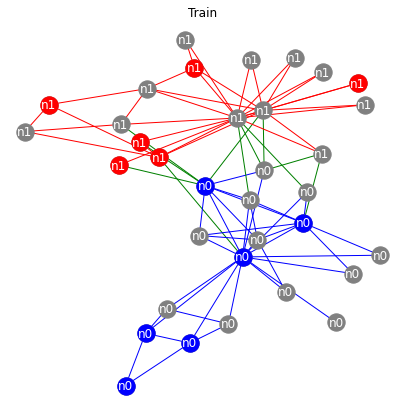

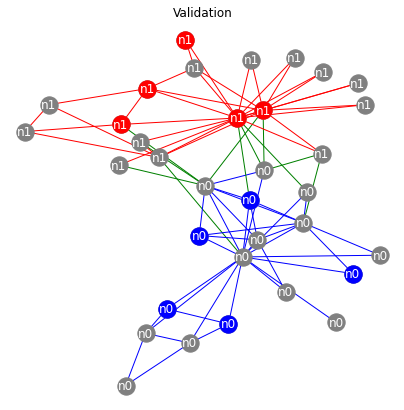

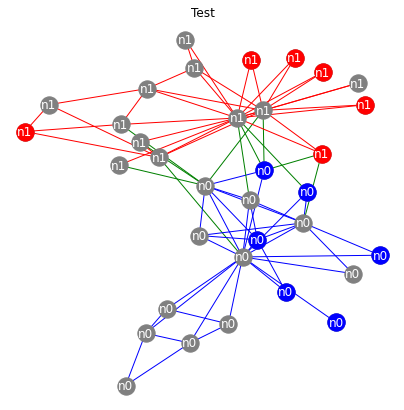

In [18]:
from deepsnap.dataset import GraphDataset

dataset = GraphDataset([hete], task='node')
# Splitting the dataset
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.4, 0.3, 0.3])
titles = ['Train', 'Validation', 'Test']

for i, dataset in enumerate([dataset_train, dataset_val, dataset_test]):
    n0 = hete._convert_to_graph_index(dataset[0].node_label_index['n0'], 'n0').tolist()
    n1 = hete._convert_to_graph_index(dataset[0].node_label_index['n1'], 'n1').tolist()

    plt.figure(figsize=(7, 7))
    plt.title(titles[i])
    nx.draw(G_orig, pos=pos, node_color="grey", edge_color=colors, labels=labels, font_color='white')
    nx.draw_networkx_nodes(G_orig.subgraph(n0), pos=pos, node_color="blue")
    nx.draw_networkx_nodes(G_orig.subgraph(n1), pos=pos, node_color="red")
    show()

# 2 异构图节点属性预测

在本章我们将使用 PyG 和 DeepSNAP 实现用于异构图节点属性预测（节点分类）的 GNN 模型。
这要求你对于异构图以及如何使用 PyG 实现 GNN 层有很好的理解。

首先让我们看看异构层大体结构的实例：

假设我们有图 $G$, 其包含两类节点 $a$、$b$, 以及三种消息类型 $m_1=(a, r_1, a)$, $m_2=(a, r_2, b)$ 以及 $m_3=(a, r_3, b)$.

因此, 对于 $G$，一个异构层将包含三个异构的 GNN 层 (即下面的 `HeteroGNNConv`)，其中每个 `HeteroGNNConv` 层都将对每个特定的消息类执行自己的消息传递以及聚合。 异构层大体如下图所示:

<br/>
<center>
<img src="https://web.stanford.edu/class/cs224w/images/colab4/hetero_conv.png"/>
</center>
<br/>

在这里, 所有的 $l^{th}$ 异构 GNN 层都会由 ($l^{th}$) 异构 GNN 修饰器（Wrapper） layer (`HeteroGNNWrapperConv`) 托管. $l^{th}$ 异构 GNN 修饰器层将接收 $(l-1)^{th}$ 层的节点嵌入为输入，并且聚合（跨消息类型的）异构 GNN 层的结果。

例如，这个修饰器层将从 $m_2$ 和 $m_3$ 的异构 GNN 层，聚合节点类型 $b$ 的节点嵌入. "简化版" 异构层结构如下所示:

<br/>
<center>
<img src="http://web.stanford.edu/class/cs224w/images/colab4/hetero_conv_1.png"/>
</center>
<br/>


<font color='red'>建议以如下步骤实现异构 GNN 模型:</font>

1. 首先实现 `HeteroGNNConv`.
2. 之后实现 `HeteroGNNWrapperConv` 中的 `mean` 聚合aggregation.
3. 实现 `generate_convs`.
4. 实现 `HeteroGNN` 模型与 `train` 函数.
5. 训练对跨消息类型执行 `mean` 聚合的模型，并获得合理的精度.
6. 在 `HeteroGNNWrapperConv` 中实现 `attn` 聚合.
5. 训练对跨消息类型执行 `attn` 聚合的模型，并获得合理的精度.


# 2 Heterogeneous Graph Node Property Prediction

In this part we will use PyTorch Geometric and DeepSNAP to implement a GNN model for heterogeneous graph node property prediction (node classification). This part of Colab requires you having good understandings on the heterogeneous graph and how to implement the GNN layers by using PyG.

At first let's take look at the general structure of a heterogeneous layer by an example.

Let's assume we have a graph $G$, which contains two node types $a$ and $b$, and three message types $m_1=(a, r_1, a)$, $m_2=(a, r_2, b)$ and $m_3=(a, r_3, b)$.

Thus, for $G$ a heterogeneous layer will contains three Heterogeneous GNN layers (`HeteroGNNConv` in this Colab) where each `HeteroGNNConv` layer will perform the message passing and aggregation with respect to only one message type. The overview of the heterogeneous layer is shown below:

<br/>
<center>
<img src="https://web.stanford.edu/class/cs224w/images/colab4/hetero_conv.png"/>
</center>
<br/>

In this Colab, all the $l^{th}$ Heterogeneous GNN layers will be managed by a ($l^{th}$) Heterogeneous GNN Wrapper layer (the `HeteroGNNWrapperConv`). The $l^{th}$ Heterogeneous GNN Wrapper layer will take in the input node embeddings from $(l-1)^{th}$ layer and aggregate (across message types) the Heterogeneous GNN layers' results. For example, the wrapper layer will aggregate node type $b$'s node embeddings from Heterogeneous GNN layers for $m_2$ and $m_3$. The "simplified" heterogeneous layer structure is shown below:

<br/>
<center>
<img src="http://web.stanford.edu/class/cs224w/images/colab4/hetero_conv_1.png"/>
</center>
<br/>


<font color='red'>We recommend you implement the heterogeneous GNN model in following steps:</font>

1. Implement the `HeteroGNNConv` first.
2. Implement the `mean` aggregation in `HeteroGNNWrapperConv`.
3. Implement the `generate_convs`.
4. Implement the `HeteroGNN` model and the `train` function.
5. Train the model with `mean` aggregation across the message types and make sure your model has reasonable performance.
6. Implement the `attn` aggregation in `HeteroGNNWrapperConv`.
7. Train the model with `attn` aggregation across the message types and make sure your model has reasonable performance.

## Setup

In [19]:
import copy
import torch
import deepsnap
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn

from sklearn.metrics import f1_score
from deepsnap.hetero_gnn import forward_op
from deepsnap.hetero_graph import HeteroGraph
from torch_sparse import SparseTensor, matmul

## Dataset
原来是需要谷歌网盘的，我直接放数据集目录里了

You need to login to your Google account and enter the verification code below.

## Heterogeneous GNN Layer

Now let's start working on our own implementation of a heterogeneous layer (the `HeteroGNNConv`)! Similar to what we did in Colab 3, we will implement the layer using PyTorch Geometric. In general, our heterogeneous GNN layer draws ideas from the **GraphSAGE** ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)).

At first, let's implement the GNN layer for each message type :

\begin{equation}
m =(s, r, d)
\end{equation}

Each message type is a tuple containing three elements where $s$ refers to the source node type, $r$ refers to the edge (relation) type and $d$ refers to the destination node type. The update rule is very similar to that of GraphSAGE but we need to include the node types and the edge type. The update rule is described as below:

\begin{equation}
h_v^{(l)[m]} = W^{(l)[m]} \cdot \text{CONCAT} \Big( W_d^{(l)[m]} \cdot h_v^{(l-1)}, W_s^{(l)[m]} \cdot AGG(\{h_u^{(l-1)}, \forall u \in N_{m}(v) \})\Big)
\end{equation}

where $[m]$ indicates that the weight matrices or embeddings with respect to message type $m$, $W_s^{(l)[m]}$ computes the messages from neighboring nodes, $W_d^{(l)[m]}$ compute messages from the node itself, and $W^{(l)[m]}$ aggregates messages from both node types. In the equation above, $v$ has the node type $d$, and $u$ has the node type $s$.

For simplicity, we use mean aggregations for $AGG$ where:

\begin{equation}
AGG(\{h_u^{(l-1)}, \forall u \in N_{m}(v) \}) = \frac{1}{|N_{m}(v)|} \sum_{u\in N_{m}(v)} h_u^{(l-1)}
\end{equation}

## 异构 GNN 层

现在让咱们开始着手实现自己的异构层 (`HeteroGNNConv`)吧! 

和在 Colab 3 中做过的类似，我们使用 PyG 来实现层. 大体上，我们这个异构 GNN 层还是用的 **GraphSAGE** ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)).

首先，来实现对每种消息类型的 GNN 层:

\begin{equation}
m =(s, r, d)
\end{equation}

每个消息类型都是包含三个元素的元组，其中 $s$ 代表源节点类型，$r$ 代表边的类型 (relation) 类型，而 $d$ 代表目标节点的类型。 更新规则与 GraphSAGE 十分类似，但是我们需要包含每种节点类型与边类型。更新规则如下述:

\begin{equation}
h_v^{(l)[m]} = W^{(l)[m]} \cdot \text{CONCAT} \Big( W_d^{(l)[m]} \cdot h_v^{(l-1)}, W_s^{(l)[m]} \cdot AGG(\{h_u^{(l-1)}, \forall u \in N_{m}(v) \})\Big)
\end{equation}

其中 $[m]$ 表示对应于消息类型 $m$ 而言嵌入的权重矩阵, $W_s^{(l)[m]}$ 计算来自邻居节点的消息, $W_d^{(l)[m]}$ 计算自身节点的消息, and $W^{(l)[m]}$ 对每种节点类型都执行消息聚合。 在上面的公式中，$v$ 的节点类型为 $d$, $u$ 的节点类型为 $s$.

为了简介期间，我们使用了均值聚合作为 $AGG$ 其中:

\begin{equation}
AGG(\{h_u^{(l-1)}, \forall u \in N_{m}(v) \}) = \frac{1}{|N_{m}(v)|} \sum_{u\in N_{m}(v)} h_u^{(l-1)}
\end{equation}

In [20]:
class HeteroGNNConv(pyg_nn.MessagePassing):
    def __init__(self, in_channels_src, in_channels_dst, out_channels):
        super(HeteroGNNConv, self).__init__(aggr="mean")

        self.in_channels_src = in_channels_src
        self.in_channels_dst = in_channels_dst
        self.out_channels = out_channels

        # To simplify implementation, please initialize both self.lin_dst
        # and self.lin_src out_features to out_channels
        # 为了实现起来简单，请将 self.lin_dst 和 self.lin_src 的 out_features 都设置为 out_channels 
        self.lin_dst = None
        self.lin_src = None

        self.lin_update = None

        ############# Your code here #############
        ## (~3 lines of code)
        ## 至多 3 行代码
        self.lin_dst=nn.Linear(in_channels_dst,out_channels)  #concat左
        self.lin_src=nn.Linear(in_channels_src,out_channels)  #concat右
        self.lin_update=nn.Linear(out_channels*2,out_channels)  #𝑊(𝑙)[𝑚]

        ##########################################

    def forward(
        self,
        node_feature_src,
        node_feature_dst,
        edge_index,
        size=None,
        res_n_id=None,
    ):
        ############# Your code here #############
        ## (~1 line of code)
        return self.propagate(edge_index,size=size,
                              node_feature_src=node_feature_src,node_feature_dst=node_feature_dst,res_n_id=res_n_id)
        #？反正感觉就是把所有参数都传递过去吧
        ##########################################

    def message_and_aggregate(self, edge_index, node_feature_src):

        ############# Your code here #############
        ## (~1 line of code)
        ## Note:
        ## 1. Different from what we implemented in Colab 3, we use message_and_aggregate
        ## to replace the message and aggregate. The benefit is that we can avoid
        ## materializing x_i and x_j, and make the implementation more efficient.
        ## 2. To implement efficiently, following PyG documentation is helpful:
        ## https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html
        ## 3. Here edge_index is torch_sparse SparseTensor.
        '''
        至多 1 行代码，注意
        1. 与我们在 Colab 3 中实现的不同，我们使用 message_and_aggregate 替换消息和聚合
        这可以避免定义 x_i 和 x_j，并且使得实现更高效。
        2. 为了高效实现，你最好 follow 这个 PyG 的文档：
        https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html
        3. 在这里 edge_index 是 torch_sparse 的 SparseTensorS
        '''
        out=matmul(edge_index,node_feature_src,reduce=self.aggr)  
        #adj_t,x,reduce='mean'

        ##########################################

        return out

    def update(self, aggr_out, node_feature_dst, res_n_id):

        ############# Your code here #############
        ## (~4 lines of code)
        aggr_out=self.lin_src(aggr_out)
        node_feature_dst=self.lin_dst(node_feature_dst)
        concat_features = torch.cat((node_feature_dst, aggr_out),dim=-1)
        aggr_out = self.lin_update(concat_features)

        ##########################################

        return aggr_out

In [21]:
x1 = torch.randn(7, 34)
x2 = torch.randn(7, 34)
x3 = torch.cat((x1,x2), dim = -1)
print(x3.shape)

x4 = torch.cat((x1, x2), dim = 0)
print(x4.shape)

torch.Size([7, 68])
torch.Size([14, 34])


## Heterogeneous GNN Wrapper Layer

After implementing the GNN layer for each message type, we need to somehow aggregate the the node embedding results (with respect to each message types) together. Here we will implement two types of message type level aggregation.

The first one is simply the mean aggregation:

\begin{equation}
h_v^{(l)} = \frac{1}{M}\sum_{m=1}^{M}h_v^{(l)[m]}
\end{equation}

Here node $v$ has the node type $d$ and $M$ is the total number of message types that the destination node type is $d$.

The other one is the semantic level attention introduced in **HAN** ([Wang et al. (2019)](https://arxiv.org/abs/1903.07293)). Instead of directly averaging on the message type aggregation results, we use attention to learn which message type result can be more important, then aggregate from all the message types. Following are the equations for semantic level attention:

\begin{equation}
e_{m} = \frac{1}{|V_{d}|} \sum_{v \in V_{d}} q_{attn}^T \cdot tanh \Big( W_{attn}^{(l)} \cdot h_v^{(l)[m]} + b \Big)
\end{equation}

where $m$ refers to message type and $d$ refers to the destination node type. Then we can compute the attention and update the $h_v^{(l)}$:

\begin{equation}
\alpha_{m} = \frac{\exp(e_{m})}{\sum_{m=1}^M \exp(e_{m})}
\end{equation}

\begin{equation}
h_v^{(l)} = \sum_{m=1}^{M} \alpha_{m} \cdot h_v^{(l)[m]}
\end{equation}

## 异构 GNN 修饰器层

在为每种消息类型实现 GNN 层之后，我们需要聚合（对应每种消息类型的）节点嵌入结果。这里我们将实现两类消息类型级别的聚合。

第一种就是最简单的均值聚合：

\begin{equation}
h_v^{(l)} = \frac{1}{M}\sum_{m=1}^{M}h_v^{(l)[m]}
\end{equation}

其中节点 $v$ 的节点类型是 $d$，而 $M$ 是目标节点为 $d$ 的消息类型总数。

另外一种聚合是语义级注意力机制，首发于 **HAN** ([Wang et al. (2019)](https://arxiv.org/abs/1903.07293))。与直接对所有消息类别的结果进行均值聚合不同，我们将使用注意力机制去学习哪种消息类型的结果更重要。语义级别注意力如下公式所示：

\begin{equation}
e_{m} = \frac{1}{|V_{d}|} \sum_{v \in V_{d}} q_{attn}^T \cdot tanh \Big( W_{attn}^{(l)} \cdot h_v^{(l)[m]} + b \Big)
\end{equation}

其中 $m$ 是消息类型而 $d$ 是目标节点类型。我们可以计算注意力并更新 $h_v^{(l)}$:

\begin{equation}
\alpha_{m} = \frac{\exp(e_{m})}{\sum_{m=1}^M \exp(e_{m})}
\end{equation}

\begin{equation}
h_v^{(l)} = \sum_{m=1}^{M} \alpha_{m} \cdot h_v^{(l)[m]}
\end{equation}



In [24]:
# 参考文档：https://snap.stanford.edu/deepsnap/modules/hetero_gnn.html

class HeteroGNNWrapperConv(deepsnap.hetero_gnn.HeteroConv):
    def __init__(self, convs, args, aggr="mean"):
        super(HeteroGNNWrapperConv, self).__init__(convs, None)
        self.aggr = aggr

        # Map the index and message type
        self.mapping = {}

        # A numpy array that stores the final attention probability
        self.alpha = None

        self.attn_proj = None

        if self.aggr == "attn":
            ############# Your code here #############
            ## (~1 line of code)
            ## Note:
            ## 1. Initialize self.attn_proj here.
            ## 2. You should use nn.Sequential for self.attn_proj
            ## 3. nn.Linear and nn.Tanh are useful.
            ## 4. You can create a vector parameter by using:
            ## nn.Linear(some_size, 1, bias=False)
            ## 5. The first linear layer should have out_features as args['attn_size']
            ## 6. You can assume we only have one "head" for the attention.
            ## 7. We recommend you to implement the mean aggregation first. After 
            ## the mean aggregation works well in the training, then you can 
            ## implement this part.
            '''
            至多一行代码可还行：
            1. 初始化 self.atten_proj
            2. 对 self.atten_proj 使用 nn.Sequential
            3. 使用 nn.Linear 和 nn.Tanh
            4. 你可以使用 nn.Linear(some_size, 1, bias=False) 创建一个向量参数
            5. 第一个线性层的 out_feature 应该是 args['attn_size']
            6. 你可以假设注意力只有一个"头"
            7. 建议先实现均值聚合，在均值聚合搞差不多了之后再回过头来实现这个部分
            '''
            self.attn_proj = nn.Sequential(
                nn.Linear(args['hidden_size'], args['attn_size']),  #Wh+b
                nn.Tanh(),
                nn.Linear(args['attn_size'], 1, bias=False), # q_semantic_attention
            )

            ##########################################
    
    def reset_parameters(self):
        super(HeteroConvWrapper, self).reset_parameters()
        if self.aggr == "attn":
            for layer in self.attn_proj.children():
                layer.reset_parameters()
    
    def forward(self, node_features, edge_indices):
        message_type_emb = {}
        for message_key, message_type in edge_indices.items():
            src_type, edge_type, dst_type = message_key
            node_feature_src = node_features[src_type]
            node_feature_dst = node_features[dst_type]
            edge_index = edge_indices[message_key]
            message_type_emb[message_key] = (
                self.convs[message_key](
                    node_feature_src,
                    node_feature_dst,
                    edge_index,
                )
            )
        node_emb = {dst: [] for _, _, dst in message_type_emb.keys()}
        mapping = {}        
        for (src, edge_type, dst), item in message_type_emb.items():
            mapping[len(node_emb[dst])] = (src, edge_type, dst)
            node_emb[dst].append(item)
        self.mapping = mapping
        for node_type, embs in node_emb.items():
            if len(embs) == 1:
                node_emb[node_type] = embs[0]
            else:
                node_emb[node_type] = self.aggregate(embs)
        return node_emb
    
    def aggregate(self, xs):
        # TODO: Implement this function that aggregates all message type results.
        # Here, xs is a list of tensors (embeddings) with respect to message 
        # type aggregation results.
        '''
        TODO：实现函数，聚合每种消息类型结果。
        这里 xs 是对应于聚合结果消息类型的 tensor（嵌入）的列表。
        '''
        if self.aggr == "mean":

            ############# Your code here #############
            ## (~2 lines of code)
            x = torch.stack(xs, dim=-1)
            return x.mean(dim=-1)
            #答案写法：out = torch.mean(torch.stack(xs), dim=0)
            #return out

            ##########################################

        elif self.aggr == "attn":

            ############# Your code here #############
            ## (~10 lines of code)
            ## Note:
            ## 1. Store the value of attention alpha (as a numpy array) to self.alpha,
            ## which has the shape (len(xs), ) self.alpha will be not be used 
            ## to backpropagate etc. in the model. We will use it to see how much 
            ## attention the layer pays on different message types.
            ## 2. torch.softmax and torch.cat are useful.
            ## 3. You might need to reshape the tensors by using the 
            ## `view()` function https://pytorch.org/docs/stable/tensor_view.html
            '''
            至多 10 行代码，注意：
            1. 存储注意力 alpha（为一个 np.array）到self.alpha 中，其形状为(len(xs), )
            self.alpha 不会用于反向传播。我们将用它观察不同消息类型的注意力有多大
            2. 记得用 torch.softmax 和 torch.cat
            3. 为了 reshape Tensor，你可以参考 `view()` 函数的官方文档：
             https://pytorch.org/docs/stable/tensor_view.html
            '''
            N = xs[0].shape[0] # Number of nodes for that node type
            M = len(xs) # Number of message types for that node type

            x = torch.cat(xs, dim=0).view(M, N, -1) # M * N * D
            z = self.attn_proj(x).view(M, N) # M * N * 1
            z = z.mean(1) # M * 1
            alpha = torch.softmax(z, dim=0) # M * 1

            # Store the attention result to self.alpha as np array
            self.alpha = alpha.view(-1).data.cpu().numpy()
  
            alpha = alpha.view(M, 1, 1)
            x = x * alpha
            return x.sum(dim=0)
            #答案写法：x = self.attn_proj(torch.stack(xs, dim=0))
            #x = torch.mean(x, dim=1)

            #self.alpha = torch.softmax(x, dim=0)
            #self.alpha = self.alpha.detach()

            #out = torch.stack(xs, dim=0)
            #out = self.alpha.unsqueeze(-1) * out

            #out = torch.sum(out, dim=0)
            #return out

            ##########################################

## Initialize Heterogeneous GNN Layers

Now let's initialize the Heterogeneous GNN Layers. Different from homogeneous graph case, heterogeneous case can be a little bit complex.

In general, we need to create a dictionary of `HeteroGNNConv` layers where the keys are message types.

* To get all message types, `deepsnap.hetero_graph.HeteroGraph.message_types` is useful.
* If we are initializing the first conv layers, we need to get the feature dimension of each node type. Using `deepsnap.hetero_graph.HeteroGraph.num_node_features(node_type)` will return the node feature dimension of `node_type`. In this function, we will set each `HeteroGNNConv` `out_channels` to be `hidden_size`.
* If we are not initializing the first conv layers, all node types will have the same embedding dimension `hidden_size` and we still set `HeteroGNNConv` `out_channels` to be `hidden_size` for simplicity.



## 初始化异构 GNN 层

现在让我们初始化异构 GNN 层。与同构图的例子不同，异构图更加复杂。

总而言之, 我们需要创建一个 `HeteroGNNConv` 层的字典，其中键值为消息类型

* 为了获得所有的消息类型，可以使用 `deepsnap.hetero_graph.HeteroGraph.message_types`.
* 如果我们在初始化第一个 conv layers, 我们需要获得每个节点类型的特征维度，这就要用到 `deepsnap.hetero_graph.HeteroGraph.num_node_features(node_type)` 来返回节点类型 `node_type` 对应的特征维度. 在这个函数中，我们将每个 `HeteroGNNConv` 的 `out_channels` 设置为 `hidden_size`.
* 如果我们不初始化第一个卷积层，所有的节点类型都将有相同的嵌入维度 `hidden_size` 而我们还是得把 `HeteroGNNConv` 的 `out_channels` 设置为 `hidden_size`



In [25]:
def generate_convs(hetero_graph, conv, hidden_size, first_layer=False):
    # TODO: Implement this function that returns a dictionary of `HeteroGNNConv` 
    # layers where the keys are message types. `hetero_graph` is deepsnap `HeteroGraph`
    # object and the `conv` is the `HeteroGNNConv`.
    '''
    TODO: 实现函数，返回 `HeteroGNNConv` 层组成的字典，键值为消息类型。
    `hetero_graph` 是 deepsnap `HeteroGraph` 对象， `conv` 是 `HeteroGNNConv`.
    '''
    convs = {}

    ############# Your code here #############
    ## (~9 lines of code)
    ## 至多 9 行代码
    for message_type in hetero_graph.message_types:
        if first_layer is True:
            src_type = message_type[0]
            dst_type = message_type[2]
            src_size = hetero_graph.num_node_features(src_type)
            dst_size = hetero_graph.num_node_features(dst_type)
            convs[message_type] = conv(src_size,dst_size, hidden_size)
        else:
            convs[message_type] = conv(hidden_size, hidden_size, hidden_size)    


    ##########################################
    
    return convs

## HeteroGNN

Now we will make a simple HeteroGNN model which contains only two `HeteroGNNWrapperConv` layers.

For the forward function in `HeteroGNN`, the model is going to be run as following:

self.convs1 $\rightarrow$ self.bns1 $\rightarrow$ self.relus1 $\rightarrow$ self.convs2 $\rightarrow$ self.bns2 $\rightarrow$ self.relus2 $\rightarrow$ self.post_mps

## HeteroGNN

现在我们实现一个只包含两个`HeteroGNNWrapperConv` 层的简单 HeteroGNN 模型.

`HeteroGNN` 的前向大概就如下所述:

self.convs1 $\rightarrow$ self.bns1 $\rightarrow$ self.relus1 $\rightarrow$ self.convs2 $\rightarrow$ self.bns2 $\rightarrow$ self.relus2 $\rightarrow$ self.post_mps

In [26]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, hetero_graph, args, aggr="mean"):
        super(HeteroGNN, self).__init__()

        self.aggr = aggr
        self.hidden_size = args['hidden_size']

        self.convs1 = None
        self.convs2 = None

        self.bns1 = nn.ModuleDict()
        self.bns2 = nn.ModuleDict()
        self.relus1 = nn.ModuleDict()
        self.relus2 = nn.ModuleDict()
        self.post_mps = nn.ModuleDict()

        ############# Your code here #############
        ## (~10 lines of code)
        ## Note:
        ## 1. For self.convs1 and self.convs2, call generate_convs at first and then
        ## pass the returned dictionary of `HeteroGNNConv` to `HeteroGNNWrapperConv`.
        ## 2. For self.bns, self.relus and self.post_mps, the keys are node_types.
        ## `deepsnap.hetero_graph.HeteroGraph.node_types` will be helpful.
        ## 3. Initialize all batchnorms to torch.nn.BatchNorm1d(hidden_size, eps=1.0).
        ## 4. Initialize all relus to nn.LeakyReLU().
        ## 5. For self.post_mps, each value in the ModuleDict is a linear layer 
        ## where the `out_features` is the number of classes for that node type.
        ## `deepsnap.hetero_graph.HeteroGraph.num_node_labels(node_type)` will be
        ## useful.
        '''
        至多 10 行代码，注意：
        1. 对于 self.convs1 和 self.convs2, 首先调用 generate_convs，
        之后将返回的字典（`HeteroGNNConv`）传递给 `HeteroGNNWrapperConv`
        2. 对于 self.bns, self.relus 和 self.post_mps, 键值是 node_types，
        使用 `deepsnap.hetero_graph.HeteroGraph.node_types` 吧
        3. 初始化 BN 为 torch.nn.BatchNorm1d(hidden_size, eps=1.0)
        4. 舒适化所有的 relus 为 nn.LeakyReLU()
        5. 对于 self.post_mps， 每个 ModuleDict 的值都是线性层，
        其中 `out_features` 是那个节点类型中类别的数量
        使用 `deepsnap.hetero_graph.HeteroGraph.num_node_labels(node_type)` 吧
        '''
        convs1 = generate_convs(hetero_graph, HeteroGNNConv, self.hidden_size, first_layer=True)
        convs2 = generate_convs(hetero_graph, HeteroGNNConv, self.hidden_size)

        self.convs1 = HeteroGNNWrapperConv(convs1, args, aggr=self.aggr)
        self.convs2 = HeteroGNNWrapperConv(convs2, args, aggr=self.aggr)

        for node_type in hetero_graph.node_types:
            self.bns1[node_type] = torch.nn.BatchNorm1d(self.hidden_size, eps=1)
            self.bns2[node_type] = torch.nn.BatchNorm1d(self.hidden_size, eps=1)
            self.post_mps[node_type] = nn.Linear(self.hidden_size, hetero_graph.num_node_labels(node_type))
            self.relus1[node_type] = nn.LeakyReLU()
            self.relus2[node_type] = nn.LeakyReLU()

        ##########################################

    def forward(self, node_feature, edge_index):
        # TODO: Implement the forward function. Notice that `node_feature` is 
        # a dictionary of tensors where keys are node types and values are 
        # corresponding feature tensors. The `edge_index` is a dictionary of 
        # tensors where keys are message types and values are corresponding
        # edge index tensors (with respect to each message type).
        '''
        TODO: 实现前向函数，注意 `node_feature` 是一个 Tensor 的字典，
        其中键值为节点类型，对应值为相应的特征向量。 
        `edge_index` 也是字典，键值是消息类型，值是对应的边索引 tensor（对应于每个消息类型）
        '''
        x = node_feature

        ############# Your code here #############
        ## (~7 lines of code)
        ## Note:
        ## 1. `deepsnap.hetero_gnn.forward_op` can be helpful.
        '''
        至多 7 行，可以用 `deepsnap.hetero_gnn.forward_op`
        '''
        x = self.convs1(x, edge_index)
        x = forward_op(x, self.bns1)
        x = forward_op(x, self.relus1)
        x = self.convs2(x, edge_index)
        x = forward_op(x, self.bns2)
        x = forward_op(x, self.relus2)
        x = forward_op(x, self.post_mps)

        ##########################################
        
        return x

    def loss(self, preds, y, indices):
        
        loss = 0
        loss_func = F.cross_entropy

        ############# Your code here #############
        ## (~3 lines of code)
        ## Note:
        ## 1. For each node type in preds, accumulate computed loss to `loss`
        ## 2. Loss need to be computed with respect to the given index
        '''
        至多 3 行，注意：
        1. 对于 preds 中的每个节点类型，将 loss 的结果累加到 `loss` 上
        2. Loss 需要关于给定的索引计算
        '''
        for node_type in preds:
            idx = indices[node_type]
            loss += loss_func(preds[node_type][idx], y[node_type][idx])
        ##########################################

        return loss

## Training and Testing

Here we provide you with the functions to train and test. You only need to implement one line of code here.

**Please do not modify other parts in `train` and `test` for grading purposes.**

## 训练与测试

这里把大部分训练测试的代码都写好了，你加一行就行


In [27]:
def train(model, optimizer, hetero_graph, train_idx):
    model.train()
    optimizer.zero_grad()
    preds = model(hetero_graph.node_feature, hetero_graph.edge_index)

    loss = None

    ############# Your code here #############
    ## Note:
    ## 1. `deepsnap.hetero_graph.HeteroGraph.node_label` is useful
    ## 2. Compute the loss here
    '''
    写一行：
    1. 用 `deepsnap.hetero_graph.HeteroGraph.node_label` 
    2. 这行是用来算损失的 
    '''
    loss = model.loss(preds, hetero_graph.node_label, train_idx)

    ##########################################

    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, graph, indices, best_model=None, best_val=0):
    model.eval()
    accs = []
    for index in indices:
        preds = model(graph.node_feature, graph.edge_index)
        num_node_types = 0
        micro = 0
        macro = 0
        for node_type in preds:
            idx = index[node_type]
            pred = preds[node_type][idx]
            pred = pred.max(1)[1]
            label_np = graph.node_label[node_type][idx].cpu().numpy()
            pred_np = pred.cpu().numpy()
            micro = f1_score(label_np, pred_np, average='micro')
            macro = f1_score(label_np, pred_np, average='macro')
            num_node_types += 1
        # Averaging f1 score might not make sense, but in our example we only
        # have one node type
        micro /= num_node_types
        macro /= num_node_types
        accs.append((micro, macro))
    if accs[1][0] > best_val:
        best_val = accs[1][0]
        best_model = copy.deepcopy(model)
    return accs, best_model, best_val

In [28]:
# Please do not change the following parameters
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'hidden_size': 64,
    'epochs': 100,
    'weight_decay': 1e-5,
    'lr': 0.003,
    'attn_size': 32,
}

## Dataset and Preprocessing

In the next, we will load the data and create a tensor backend (without a NetworkX graph) `deepsnap.hetero_graph.HeteroGraph` object.

We will use the `ACM(3025)` dataset in our node property prediction task, which is proposed in **HAN** ([Wang et al. (2019)](https://arxiv.org/abs/1903.07293)) and our dataset is extracted from [DGL](https://www.dgl.ai/)'s [ACM.mat](https://data.dgl.ai/dataset/ACM.mat).

The original ACM dataset has three node types and two edge (relation) types. For simplicity, we simplify the heterogeneous graph to one node type and two edge types (shown below). This means that in our heterogeneous graph, we have one node type (paper) and two message types (paper, author, paper) and (paper, subject, paper).

<br/>
<center>
<img src="http://web.stanford.edu/class/cs224w/images/colab4/cs224w-acm.png"/>
</center>

## 数据集与预处理

接下来我们将加载数据，并创建一个(没有 NetworkX 图的) Tensor 后端：  `deepsnap.hetero_graph.HeteroGraph` 对象.

我们将使用 `ACM(3025)` 作为节点属性预测任务的数据集， 他被提出于 **HAN** ([Wang et al. (2019)](https://arxiv.org/abs/1903.07293)) ，数据集的来源为 [DGL](https://www.dgl.ai/) 的 [ACM.mat](https://data.dgl.ai/dataset/ACM.mat).

原始的 ACM 数据集有三个节点类型和两个边（关系）类型。为了简单起见，我们简化了异构图为一个节点类型和两个边类型（如下图所示）。这意味着在我们的异构图中，我们只有一个节点类型（paper）和两个消息类型，即 (paper, author, paper) 与 (paper, subject, paper).

<br/>
<center>
<img src="http://web.stanford.edu/class/cs224w/images/colab4/cs224w-acm.png"/>
</center>

In [29]:
print("Device: {}".format(args['device']))

# Load the data
data = torch.load("datasets/acm.pkl")

# Message types
message_type_1 = ("paper", "author", "paper")
message_type_2 = ("paper", "subject", "paper")

# Dictionary of edge indices
edge_index = {}
edge_index[message_type_1] = data['pap']
edge_index[message_type_2] = data['psp']

# Dictionary of node features
node_feature = {}
node_feature["paper"] = data['feature']

# Dictionary of node labels
node_label = {}
node_label["paper"] = data['label']

# Load the train, validation and test indices
train_idx = {"paper": data['train_idx'].to(args['device'])}
val_idx = {"paper": data['val_idx'].to(args['device'])}
test_idx = {"paper": data['test_idx'].to(args['device'])}

# Construct a deepsnap tensor backend HeteroGraph
hetero_graph = HeteroGraph(
    node_feature=node_feature,
    node_label=node_label,
    edge_index=edge_index,
    directed=True
)

print(f"ACM heterogeneous graph: {hetero_graph.num_nodes()} nodes, {hetero_graph.num_edges()} edges")

# Node feature and node label to device
for key in hetero_graph.node_feature:
    hetero_graph.node_feature[key] = hetero_graph.node_feature[key].to(args['device'])
for key in hetero_graph.node_label:
    hetero_graph.node_label[key] = hetero_graph.node_label[key].to(args['device'])

# Edge_index to sparse tensor and to device
for key in hetero_graph.edge_index:
    edge_index = hetero_graph.edge_index[key]
    adj = SparseTensor(row=edge_index[0], col=edge_index[1], sparse_sizes=(hetero_graph.num_nodes('paper'), hetero_graph.num_nodes('paper')))
    hetero_graph.edge_index[key] = adj.t().to(args['device'])
print(hetero_graph.edge_index[message_type_1])
print(hetero_graph.edge_index[message_type_2])

Device: cuda
ACM heterogeneous graph: {'paper': 3025} nodes, {('paper', 'author', 'paper'): 26256, ('paper', 'subject', 'paper'): 2207736} edges
SparseTensor(row=tensor([   0,    0,    0,  ..., 3024, 3024, 3024], device='cuda:0'),
             col=tensor([   8,   20,   51,  ..., 2948, 2983, 2991], device='cuda:0'),
             size=(3025, 3025), nnz=26256, density=0.29%)
SparseTensor(row=tensor([   0,    0,    0,  ..., 3024, 3024, 3024], device='cuda:0'),
             col=tensor([  75,  434,  534,  ..., 3020, 3021, 3022], device='cuda:0'),
             size=(3025, 3025), nnz=2207736, density=24.13%)


## Start Training!

Now lets start training!

## 开始训练吧！

## Training the Mean Aggregation

## 训练均值聚合

In [30]:
best_model = None
best_val = 0

model = HeteroGNN(hetero_graph, args, aggr="mean").to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

for epoch in range(args['epochs']):
    loss = train(model, optimizer, hetero_graph, train_idx)
    accs, best_model, best_val = test(model, hetero_graph, [train_idx, val_idx, test_idx], best_model, best_val)
    print(
        f"Epoch {epoch + 1}: loss {round(loss, 5)}, "
        f"train micro {round(accs[0][0] * 100, 2)}%, train macro {round(accs[0][1] * 100, 2)}%, "
        f"valid micro {round(accs[1][0] * 100, 2)}%, valid macro {round(accs[1][1] * 100, 2)}%, "
        f"test micro {round(accs[2][0] * 100, 2)}%, test macro {round(accs[2][1] * 100, 2)}%"
    )
best_accs, _, _ = test(best_model, hetero_graph, [train_idx, val_idx, test_idx])
print(
    f"Best model: "
    f"train micro {round(best_accs[0][0] * 100, 2)}%, train macro {round(best_accs[0][1] * 100, 2)}%, "
    f"valid micro {round(best_accs[1][0] * 100, 2)}%, valid macro {round(best_accs[1][1] * 100, 2)}%, "
    f"test micro {round(best_accs[2][0] * 100, 2)}%, test macro {round(best_accs[2][1] * 100, 2)}%"
)

Epoch 1: loss 1.09922, train micro 33.33%, train macro 16.67%, valid micro 33.33%, valid macro 16.67%, test micro 32.89%, test macro 16.5%
Epoch 2: loss 1.08845, train micro 88.17%, train macro 87.76%, valid micro 86.33%, valid macro 85.68%, test micro 74.21%, test macro 73.84%
Epoch 3: loss 1.05426, train micro 80.0%, train macro 77.75%, valid micro 76.67%, valid macro 73.26%, test micro 66.49%, test macro 58.92%
Epoch 4: loss 0.98567, train micro 72.33%, train macro 65.46%, valid micro 70.33%, valid macro 62.22%, test micro 66.07%, test macro 55.44%
Epoch 5: loss 0.87204, train micro 69.83%, train macro 61.3%, valid micro 68.0%, valid macro 57.94%, test micro 65.74%, test macro 54.39%
Epoch 6: loss 0.71742, train micro 69.17%, train macro 60.32%, valid micro 67.33%, valid macro 56.76%, test micro 65.65%, test macro 54.28%
Epoch 7: loss 0.55155, train micro 69.0%, train macro 60.12%, valid micro 67.67%, valid macro 57.61%, test micro 65.65%, test macro 54.29%
Epoch 8: loss 0.40637, tr

## Question 2.1: What is the maximum **micro** F1 score you could get for the best_model on test set when using the mean aggregation? (10 points)

Submit your answers on Gradescope.

## Question 2.2: What is the maximum **macro** F1 score you could get for the best_model on test set when using the mean aggregation? (10 points)

Submit your answers on Gradescope.

## Training the Attention Aggregation

## 训练注意力聚合

In [32]:
best_model = None
best_val = 0

output_size = hetero_graph.num_node_labels('paper')
model = HeteroGNN(hetero_graph, args, aggr="attn").to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

for epoch in range(args['epochs']):
    loss = train(model, optimizer, hetero_graph, train_idx)
    accs, best_model, best_val = test(model, hetero_graph, [train_idx, val_idx, test_idx], best_model, best_val)
    print(
        f"Epoch {epoch + 1}: loss {round(loss, 5)}, "
        f"train micro {round(accs[0][0] * 100, 2)}%, train macro {round(accs[0][1] * 100, 2)}%, "
        f"valid micro {round(accs[1][0] * 100, 2)}%, valid macro {round(accs[1][1] * 100, 2)}%, "
        f"test micro {round(accs[2][0] * 100, 2)}%, test macro {round(accs[2][1] * 100, 2)}%"
    )
best_accs, _, _ = test(best_model, hetero_graph, [train_idx, val_idx, test_idx])
print(
    f"Best model: "
    f"train micro {round(best_accs[0][0] * 100, 2)}%, train macro {round(best_accs[0][1] * 100, 2)}%, "
    f"valid micro {round(best_accs[1][0] * 100, 2)}%, valid macro {round(best_accs[1][1] * 100, 2)}%, "
    f"test micro {round(best_accs[2][0] * 100, 2)}%, test macro {round(best_accs[2][1] * 100, 2)}%"
)

Epoch 1: loss 1.09961, train micro 33.33%, train macro 16.67%, valid micro 33.33%, valid macro 16.67%, test micro 35.81%, test macro 17.58%
Epoch 2: loss 1.09259, train micro 33.5%, train macro 17.02%, valid micro 33.33%, valid macro 16.67%, test micro 35.81%, test macro 17.58%
Epoch 3: loss 1.06592, train micro 65.83%, train macro 54.86%, valid micro 65.33%, valid macro 54.58%, test micro 59.58%, test macro 49.97%
Epoch 4: loss 1.00927, train micro 66.33%, train macro 54.56%, valid micro 66.0%, valid macro 54.67%, test micro 64.94%, test macro 53.64%
Epoch 5: loss 0.91001, train micro 66.83%, train macro 55.33%, valid micro 65.67%, valid macro 53.51%, test micro 64.85%, test macro 53.0%
Epoch 6: loss 0.76388, train micro 69.83%, train macro 61.44%, valid micro 66.33%, valid macro 54.77%, test micro 64.28%, test macro 52.35%
Epoch 7: loss 0.59046, train micro 73.17%, train macro 67.28%, valid micro 68.33%, valid macro 58.5%, test micro 64.56%, test macro 52.91%
Epoch 8: loss 0.42704, t

## Question 2.3: What is the maximum **micro** F1 score you could get for the best_model on test set when using the attention aggregation? (4 points)

Submit your answers on Gradescope.

## Question 2.4: What is the maximum **macro** F1 score you could get for the best_model on test set when using the attention aggregation? (4 points)

Submit your answers on Gradescope.

## Attention for each Message Type

Through message type level attention we can learn that which message type is more important to which layer.

Here we will print out and show that each layer pay how much attention on each message type.

## 每种消息类型的注意力

在消息类型注意力中，我们可以发现对于某一层更重要的消息类型是什么

现在我们将打印每个层对于每种消息类型有多大的注意力


In [33]:
if model.convs1.alpha is not None and model.convs2.alpha is not None:
    for idx, message_type in model.convs1.mapping.items():
        print(f"Layer 1 has attention {model.convs1.alpha[idx]} on message type {message_type}")
    for idx, message_type in model.convs2.mapping.items():
        print(f"Layer 2 has attention {model.convs2.alpha[idx]} on message type {message_type}")

Layer 1 has attention 0.30699798464775085 on message type ('paper', 'author', 'paper')
Layer 1 has attention 0.6930020451545715 on message type ('paper', 'subject', 'paper')
Layer 2 has attention 0.6440726518630981 on message type ('paper', 'author', 'paper')
Layer 2 has attention 0.35592731833457947 on message type ('paper', 'subject', 'paper')


# Submission

In order to get credit, you must go submit your answers on Gradescope.

Also, you need to submit the `ipynb` file of Colab 4, by clicking `File` and `Download .ipynb`. Please make sure that your output of each cell is available in your `ipynb` file.